# Explotatory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

# Managing Categorical Data
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder    
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Managing Missing Values
from sklearn.base import BaseEstimator, TransformerMixin

# Make a pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Scaling
from sklearn.preprocessing import StandardScaler

#Models
from sklearn.linear_model import LogisticRegression

#Tunning
from sklearn.model_selection import GridSearchCV, cross_val_score

# PERFORMANCE METRICS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 1. The problem


Dado el siguente Dataset:

https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

Crear un Jupyter Notebook con los siguientes elementos

8 puntos -> Un Análisis Exploratorio de Datos enfocándose especialmente en responder la siguiente pregunta de negocio ¿Qué factores están relacionados con que los pasajeros tengan una mayor/menor probabilidad de sobrevivir?

2 puntos -> Entrena un algoritmo de Regresión Logística para que sea capaz de clasificar adecuadamente a los pasajeros entre los que sobrevivieron y no sobrevivieron (variable "Survived").

La parte del algoritmo de Regresión Logística no se tiene en cuenta de cara a aprobar/suspender, pero si quieres optar a sacar más de un 8 es necesario su realización.

Es importante comentar en detalle en celdas de "Markdown" que se está haciendo en cada paso, y por qué, así como tus opiniones y razonamientos sobre los resultados obtenidos.

## 2. EDA & Feature Engeneering

### 2.1. Load the data

In [2]:
train_data = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv", sep=",", index_col="PassengerId")
print(train_data.shape)
train_data.head(10)

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


### 2.2. Outlier Detection

**Tukey’s method** is widely used for exploratory data analysis and has become a standard approach for identifying outliers in statistical and data analysis practices. John Tukey looks at the data’s spread using the Interquartile Range (IQR). 

Tukey defined outliers as those points that fall **below Q1 – 1.5*IQR** or **above Q3 + 1.5*IQR**, providing a clear, quantitative criterion for identifying data points that are significantly different from the bulk of the data in a set.

In [3]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns that is decided to apply Tukey´s method for detecting outliers.
    Returns a list of indices that are considered outliers.

    Parameters
    ----------
    data : pd.dataframe
    features : python list

    Returns
    -------
    python list
        Returns a list with the indices of "data" which are considered outliers 
    """
    outlier_indices = []
    n = 2 # treshold
    
    # Iterate over each feature
    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # Outlier step
        outlier_step = 1.5 * IQR
        
        # Determine the index of the outliers for feature column
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
        
        # Append indices of outliers for every col 
        outlier_indices.extend(outlier_list_col)
        
    # Count occurrences of each index
    outlier_count = Counter(outlier_indices)
    
    # Select indices with more than n outliers
    outliers_list = [index for index, count in outlier_count.items() if count > n]
    
    return outliers_list

In [4]:
outliers_to_drop = outlier_detection(train_data, ["Age", "SibSp", "Parch", "Fare"])
outliers_to_drop

[28, 89, 160, 181, 202, 325, 342, 793, 847, 864]

In [5]:
# show the detected outliers
train_data.loc[outliers_to_drop]  

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


I have detected 10 outliers.

The next three passengers: 28, 89 and 342 → outliers because of high Ticket Fare.

The remaining seven passengers → high values # of siblings.

In [6]:
# Drop outliers
train_data_outliers = train_data.copy()  # save the original dataset

train_data = train_data.drop(outliers_to_drop, axis=0).reset_index(drop=True)

print(train_data_outliers.shape)
print(train_data.shape)

(891, 11)
(881, 11)


### 2.3. Exploring the dataset

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  881 non-null    int64  
 1   Pclass    881 non-null    int64  
 2   Name      881 non-null    object 
 3   Sex       881 non-null    object 
 4   Age       711 non-null    float64
 5   SibSp     881 non-null    int64  
 6   Parch     881 non-null    int64  
 7   Ticket    881 non-null    object 
 8   Fare      881 non-null    float64
 9   Cabin     201 non-null    object 
 10  Embarked  879 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 75.8+ KB


First of all I can see that Age, Cabin and Embarked have missing values. After exploring the data, I will manage the misssing data.

The columns Survived, Pclass, Age, SibSp, Parch, Fare are numerical data. The rest of the features are categorical.

#### 2.3.1. Exploring the Numerical Data

In [8]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


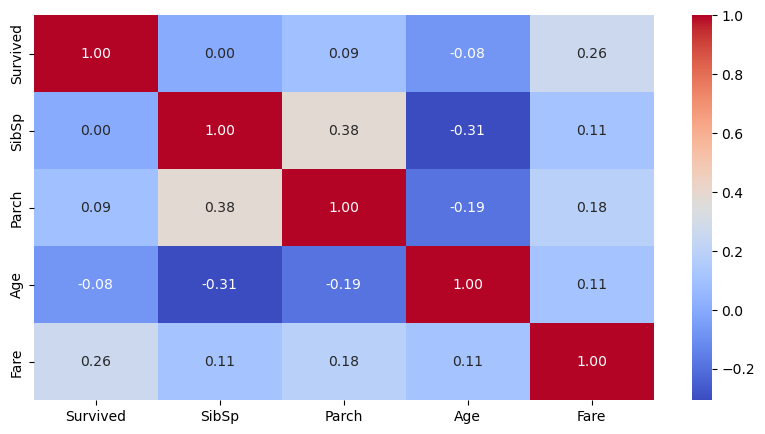

In [9]:
correlation_matix = train_data[["Survived","SibSp","Parch","Age","Fare"]].corr()
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

With the **Pearon Correlation method** is seems that only "Fare" feature seem to have some correlation with the survival probability.

It **doesn't mean that the other features are not usefull**. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

Let´s explore them by grouping.

In [10]:
# Grouping data by Ticket class
train_data.groupby(["Pclass"], as_index=False)["Survived"].mean()

,Pclass,Survived
0,1,0.629108
1,2,0.472826
2,3,0.245868


It appears that a higher ticket class is correlated with a higher probability of survival.

In [11]:
# number of siblings / spouses aboard the Titanic
train_data.groupby(["SibSp"], as_index=False)["Survived"].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.153846
4,4,0.166667
5,5,0.000000


It seems that have some a sibling/spouse increased the probability of survival than travelling alone. However, having more than 2 siblings/spouses on board drastically reduces the chance of survival, about twice as much as traveling alone.

In [12]:
# number of parents / children aboard the Titanic
train_data.groupby(["Parch"], as_index=False)["Survived"].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.542857
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


Here we have similar correlation withe the number of parents/children aboard.

We can note that not only the "Ticket Fare", but the "size of the family" on Titanic board had some importance in the probability of survival. I will take this into account in the feature engineering.

What about the age of the passengers?

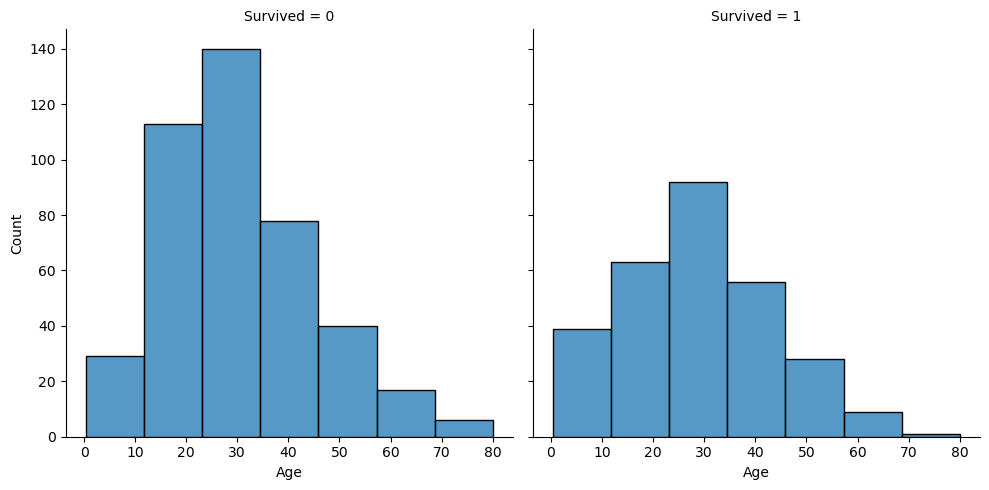

In [13]:
# Grouping by Age 
sns.displot(train_data, x="Age", col="Survived", bins=7)
plt.show()

Perhaps comparing two histograms is not the best way to visualize two continuous distributions. Let´s try with a boxplot.

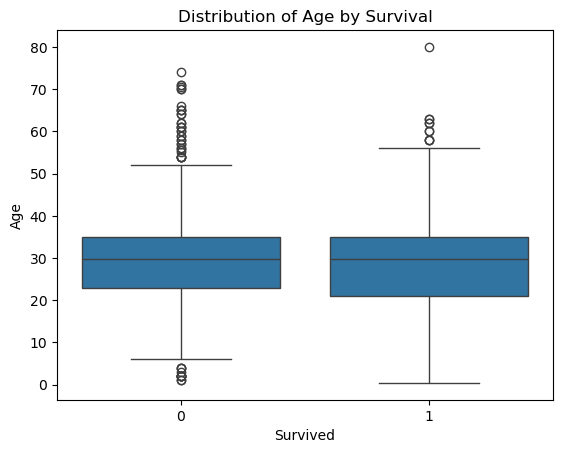

In [90]:
# Create the boxplot
sns.boxplot(data=train_data, x="Survived", y="Age")

# Add labels and title
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("Distribution of Age by Survival")
plt.show()

The age distribution shows a significant concentration of passengers in the 25 to 35 age range, both for those who survived and those who died. 

However, the most of the passengers (IQR) who survived and those who died were concentrated in a specific age range, which is approximately 25 to 35 years old. This concentration suggests that age was an important factor in the probability of survival.

There are several reasons why this age concentration may have influenced the chances of survival: physical condition and mobility, experience and decision-making capacity.

Finally let´s explore the last column ("Fare") with Numerical Data that at first sight had more correlation than any of the other features.

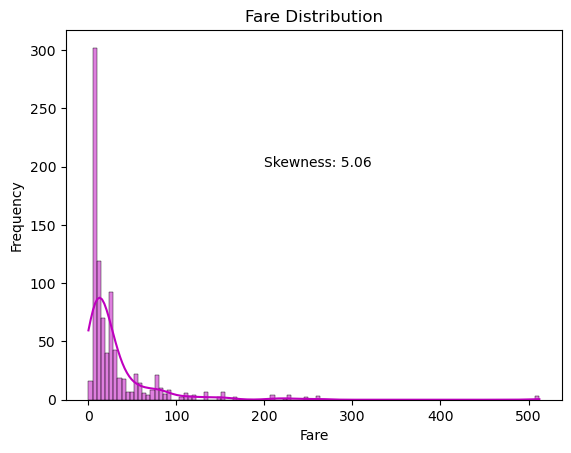

In [14]:
# Exploring Fare Distribution
sns.histplot(train_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(200, 200, "Skewness: %.2f" % train_data["Fare"].skew(), fontsize=10)
plt.show()

As we can see, Fare distribution has highly positive skewness, i.e., to the left. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce it´s skew.

$$log1p = log(1+x)$$

Remember to perform the inverse transformation to obtain the original value:

$$expm1 = exp(x) - 1$$

**This process is done in the point → *2.6. Scaling the data*.**

#### 2.3.2. Exploring the Categorical Data

In [15]:
# Groping data by Sex
train_data.groupby(["Sex"], as_index=False)["Survived"].mean()

,Sex,Survived
0,female,0.747573
1,male,0.190559


We can observe that women are more likely to survive. It is likely that during the sinking of the Titanic the “women first” policy was applied when loading the lifeboats. 

In [16]:
# Grouping by Embarked → Port of Embarkation
# C = Cherbourg, Q = Queenstown, S = Southampton

train_data.groupby(["Embarked"], as_index=False)["Survived"].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339117


Passengers who embarked from Cherbourg had a higher survival rate compared to those from Queenstown or Southampton. This is possibly due to Cherbourg being the first port of call and the likelihood of more first-class passengers embarking there.

In [17]:
train_data.groupby(['Embarked', 'Pclass'])['Survived'].mean()

Embarked  Pclass
C         1         0.694118
          2         0.529412
          3         0.378788
Q         1         0.500000
          2         0.666667
          3         0.375000
S         1         0.580645
          2         0.463415
          3         0.193642
Name: Survived, dtype: float64

## 3. Data preparation

In this section I´m going to manage the missing values, drop the unnesarry features and encode the categorical data.

0.   PassengerId  → 881 non-null    → int64    → OK
1.   Survived     → 881 non-null    → int64    → OK
2.   Pclass       → 881 non-null    → int64    → OK (categorical data but already transformed like encoded ordinal data)
3.   Name         → 881 non-null    → object   → **NOT OK** (categorical data → drop the column)
4.   Sex          → 881 non-null    → object    → **NOT OK** (categorical data → encode to numerical)
5.   Age          → 711 non-null    → float64   → **NOT OK** (missing values → fill with arithmetic mean)
6.   SibSp        → 881 non-null    → int64     → OK
7.   Parch        → 881 non-null    → int64     → OK
8.   Ticket       → 881 non-null    → object    → **NOT OK** (categorical data → drop the column)
9.   Fare         → 881 non-null    → float64   → **NOT OK** (mange the skewness)
10.  Cabin        → 201 non-null    → object    → **NOT OK** (missing values → drop the column)
11.  Embarked     → 879 non-null    → object    → **NOT OK** (categorical data → encode to numerical)

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  881 non-null    int64  
 1   Pclass    881 non-null    int64  
 2   Name      881 non-null    object 
 3   Sex       881 non-null    object 
 4   Age       711 non-null    float64
 5   SibSp     881 non-null    int64  
 6   Parch     881 non-null    int64  
 7   Ticket    881 non-null    object 
 8   Fare      881 non-null    float64
 9   Cabin     201 non-null    object 
 10  Embarked  879 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 75.8+ KB


### 3.1. Fixing Null Values

The missing values are in the next columns:
* Age → 570 non-null of 720 total values → fill with the arithmetic mean
* Cabin → Just remove the column → not relevant for my simplified model
* Embarked → fill it with the most common value.

In [19]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):  # Since we don´t have really to do any fitting here
        return self            # We´re going to return just the self object because fit function → returns BaseEstimator itself
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X


class EmbarkedImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        # Find the most common value in the "Embarked" column
        self.most_common_embarked = X["Embarked"].mode()[0]
        return self
    
    def transform(self, X):
        X["Embarked"].fillna(self.most_common_embarked, inplace=True)
        return X

### 3.2. Encoding Feature

The categorical data can be found between the following columns:
* Name → drop the column, I don´t consider that the name is relevant for my simplified model
* Sex → categorical data → encode
* Cabin → too much missing values, drop the column
* Embarked → categorical data → encode

In [20]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        
        ct = make_column_transformer(
            (ohe, ["Sex", "Embarked"]),
        )
        ct.set_output(transform="pandas")
        ohe_transform = ct.fit_transform(X)
        X = pd.concat([X, ohe_transform], axis=1)
        return X

### 3.3. Dropping Features

In [21]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Sex", "Embarked", "Name", "Ticket", "Cabin"], axis=1, errors="ignore")

### 3.4. Pipeline

In this point I will execute all the decisions mentioned above.

In [22]:
# Define the pipeline
pipeline = Pipeline([
    ('age_imputer', AgeImputer()),        # Fill missing values in Age with arithmetic mean
    ('embarked_imputer', EmbarkedImputer()),  # Fill missing values in Embarked with most common value
    ('feature_encoder', FeatureEncoder()),   # OneHotEncoding for Sex and Embarked columns
    ('feature_drop', FeatureDropper())      # Drop the encoded and unnecessary columns
])

In [23]:
# Transform your training data using the pipeline
preprocessed_data = pipeline.fit_transform(train_data)

In [24]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Survived                   881 non-null    int64  
 1   Pclass                     881 non-null    int64  
 2   Age                        881 non-null    float64
 3   SibSp                      881 non-null    int64  
 4   Parch                      881 non-null    int64  
 5   Fare                       881 non-null    float64
 6   onehotencoder__Sex_female  881 non-null    float64
 7   onehotencoder__Sex_male    881 non-null    float64
 8   onehotencoder__Embarked_C  881 non-null    float64
 9   onehotencoder__Embarked_Q  881 non-null    float64
 10  onehotencoder__Embarked_S  881 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 75.8 KB


Perfect work, no missing values and no object columns.

### 3.5. Data Engineering

In [25]:
# Create Family Size Column  →  + 1 for youself
preprocessed_data["family_size"] = preprocessed_data["SibSp"] + preprocessed_data["Parch"] + 1

# Grouping by the Family Size
preprocessed_data.groupby(["family_size"], as_index=False)["Survived"].mean()

,family_size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.052632
6,7,0.333333
7,8,0.000000


I will work with two datasets making two different decisions. 
- A. Keep the columns "SibSp" and "Parch"
- B. Delete the columns "SibSp" and "Parch". Model only with "family size".

Afterward I will evaluate which decision works best for the model to have better predictions.

In [26]:
simplified_data = preprocessed_data.copy()

simplified_data.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [27]:
# check
print(simplified_data.shape)
print(preprocessed_data.shape)

(881, 10)
(881, 12)


### 3.6. Scaling Data

Before starting with the scaling process, first I will manage the **skewness** with the "Fare" feature.

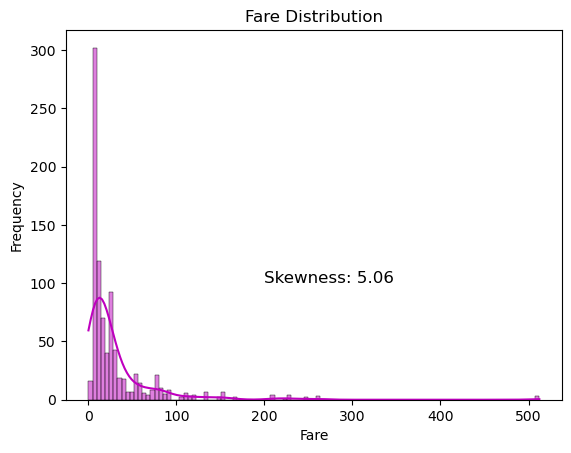

In [28]:
# Exploring Fare Distribution
sns.histplot(preprocessed_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(200, 100, "Skewness: %.2f" % train_data["Fare"].skew(), fontsize=12)
plt.show()

In [29]:
# Apply log to Fare to reduce skewness distribution
transformer = FunctionTransformer(np.log1p, validate=True)

# Obtain logarithmic values
preprocessed_data_transf = transformer.transform(preprocessed_data[["Fare"]])
simplified_data_transf = transformer.transform(simplified_data[["Fare"]])

# Replace the real values with the logarithmic ones
preprocessed_data["Fare"] = preprocessed_data_transf
simplified_data["Fare"] = simplified_data_transf

C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


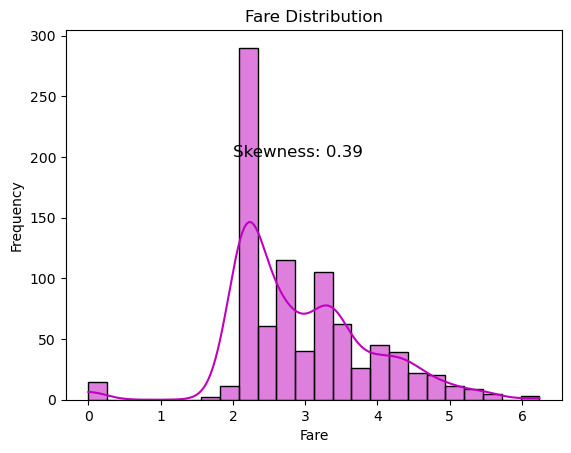

In [30]:
# Exploring Fare Distribution
sns.histplot(preprocessed_data["Fare"], color="m", kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.text(2, 200, "Skewness: %.2f" % preprocessed_data["Fare"].skew(), fontsize=12)
plt.show()

I can confirm that skewness is clearly reduced, from 5.06 to 0.39.

I will now proceed to Feature Scaling with the Standarization method (Z-score normalization). This is achieved by subtracting the mean of each feature and then dividing by its standard deviation.

<span style="font-size: 1.5em;"> $z = \frac{x - \mu}{\sigma}$ </span>

Where:

* $z$ is the standardized value,
* $x$ is the original value,
* $\mu$ is the mean of the feature,
* $\sigma$ is the standard deviation of the feature.

I will do 2 different decisions in every dataset.
- "preprocessed_data" → Standarization in every not encoded column.
- "simplified_data" → Standarization only in "Age and "Fare" column. ("family_size" won´t be scaled")

In [31]:
# Create scaler object 
scaler = StandardScaler()

# Define the columns that I will scale in every case
columns_to_scale = ["Age", "SibSp", "Parch", "Fare", "family_size"]
col_to_scale = ["Age", "Fare"]  #Simplified dataset do not scale family_size

# Extract the subset of columns to scale
preprocessed_data_subset = preprocessed_data[columns_to_scale]
simplified_data_subset = simplified_data[col_to_scale]

# Fit and transform the training data with the scaler
preprocessed_data_scaled = scaler.fit_transform(preprocessed_data_subset)
preprocessed_data_scaled = pd.DataFrame(preprocessed_data_scaled, columns=columns_to_scale)

# Fit and transform the "simplified dataset" with the scaler
simplified_data_scaled = scaler.fit_transform(simplified_data_subset)
simplified_data_scaled = pd.DataFrame(simplified_data_scaled, columns=col_to_scale)

# Concatenate the scaled columns with the original datasets
preprocessed_data = pd.concat([preprocessed_data.drop(columns=columns_to_scale), preprocessed_data_scaled], axis=1)
simplified_data = pd.concat([simplified_data.drop(columns=col_to_scale), simplified_data_scaled], axis=1)

## 4. Modelling
Before we start modeling, we have to separate the data into training set and test set.

###  <font color="green"> 4.1. *preprocessed_data* <font>

#### 4.1.1. Split the data

In [32]:
# Define X and y
X = preprocessed_data.drop(["Survived"], axis=1)
y = preprocessed_data["Survived"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 4.1.2. Define the model

In [35]:
# Define a LogisticRegression Model
model_lg = LogisticRegression(random_state = 42)

In [36]:
# Train the model
model_lg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [37]:
# Try prediction
prediction_lr = model_lg.predict(X_test)

#### 4.1.3. Performance Metrics

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, prediction_lr)
print("Accuracy:", accuracy)

Accuracy: 0.7627118644067796


<span style="font-size: 1.5em;"> $ Accuracy = \frac{Correct Predictions}{Total Predictions}$ </span>

This metric measures the overall correctness of the model's predictions. An accuracy of around 0.7627 means that approximately 76.27% of the predictions made by the model are correct. It seems to be a decent predictive model, considering the simplicity of logistic regression.

While accuracy is a useful metric, it may not provide a complete picture, especially in imbalanced datasets or when the cost of false positives and false negatives differs significantly.

In [51]:
y_test.value_counts()

Survived
0    112
1     65
Name: count, dtype: int64

Our test set  is **clearly unbalanced** because there is a difference in the number of instances between the two classes. In this case, the "Survived" class with label 0 has 112 instances (63%), while the "Survived" class with label 1 has 65 instances (37%). Tt's important to consider the implications.

Class imbalance can affect the performance of machine learning models, especially those that are sensitive to class distribution, such as Logistic Regression. In such cases, the model may become biased towards the majority class (in this case, class 0), leading to lower predictive performance for the minority class (class 1).

In [52]:
# Calculate precision
precision = precision_score(y_test, prediction_lr)
print("Precision:", precision)

Precision: 0.6949152542372882


<span style="font-size: 1.5em;"> $ Precision = \frac{TruePositive}{TruePositive + FalsePositive}$ </span>

Precision measures the proportion of true positive predictions out of all positive predictions made by the model. With a precision of 0.69, it means that out of all the instances predicted as survived, 69% of them were actually correct. 

Now, let's consider the imbalance in the dataset. Since precision is influenced by the number of true negatives (TN), and we have a large number of instances in the negative class (112), it's more probable to achieve good precision by predicting most instances as negative. In this context, a precision of 0.69 is not necessarily a bad metric, but it is not a good metric either, it should be interpreted cautiously.

In [53]:
# Calculate recall
recall = recall_score(y_test, prediction_lr)
print("Recall:", recall)

Recall: 0.6307692307692307


<span style="font-size: 1.5em;"> $ Recall = \frac{TruePositive}{TruePositive + FalseNegative}$ </span>

Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive cases (survived passengers) out of all actual positive cases in the dataset. In the context of an imbalanced dataset like the Titanic dataset, where there are fewer instances of the positive class (survived passengers), recall is an important metric to consider.

In [54]:
# Calculate F1 score
f1 = f1_score(y_test, prediction_lr)
print("F1 Score:", f1)

F1 Score: 0.6612903225806452


<span style="font-size: 1.5em;"> $ F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall}$ </span>

F1 score is the harmonic mean of precision and recall. 


To sum, while the **accuracy** of **76%** may seem promising at **first glance**, the imbalance in the dataset skews the interpretation. The **imbalance**, where the majority class (not survived) significantly outnumbers the minority class (survived), can lead to a situation where a model that simply predicts the majority class for all instances could achieve high accuracy.

In this case, with an imbalance where the majority class comprises around 63% of the data, a model that predicts all instances as not survived would achieve an accuracy of approximately 76%. But the reallity is that due to the imbalance of the data the correct prediction is around the 66%, i.e. it is not a very accurate model.

#### 4.1.4. Tunning

In [63]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.005, 0.1, 0.5, 1, 10, 100],        # Regularization strength
    'penalty': ['l1', 'l2'],                                       # L1 regularization (Lasso) or L2 regularization (Ridge)
    'solver': ['liblinear', 'lbfgs', 'saga'],                      # Solver algorithm
    'class_weight': [None, 'balanced']                             # Class weights for handling imbalanced data
}

In [67]:
# Initialize the grid search
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')

In [68]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\sklearn\linea

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.005, 0.01, 0.005, 0.1, 0.5, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

In [70]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best Accuracy Score:", best_score)

Best parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy Score: 0.7983080040526849


In [74]:
# Therefore, if the machine indicates that these are the best parameters, I select them by hand
lr_optimized = LogisticRegression(
    C = 0.1,
    class_weight = None,
    penalty = 'l2',
    solver = 'liblinear'
)

In [75]:
# Train the model with the optimized params
lr_optimized.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [76]:
prediction_lr_optimized = lr_optimized.predict(X_test)

In [77]:
# Calculate accuracy BEFORE optimization
accuracy = accuracy_score(y_test, prediction_lr)
f1_scoree = f1_score(y_test, prediction_lr)
print("Accuracy:", accuracy)
print("F1 Score:", f1_scoree)

print("-"*50)

#Calculate accuracy AFTER optimization
accuracy_opt = accuracy_score(y_test, prediction_lr_optimized)
f1_scoree_opt = f1_score(y_test, prediction_lr_optimized)
print("Accuracy optimized:", accuracy_opt)
print("F1 Score optimized:", f1_scoree_opt)

Accuracy: 0.7627118644067796
F1 Score: 0.6612903225806452
--------------------------------------------------
Accuracy optimized: 0.7627118644067796
F1 Score optimized: 0.671875


This indicates that the model's ability to balance precision and recall improved slightly after tuning the hyperparameters using grid search. However, the change in F1 score is relatively small, suggesting that the initial model may have been close to optimal for this dataset..

###  <font color="green"> 4.2. *simplified_data* <font>
Just to remind, the changes are: 
* Delete columns "SibSp" and "Parch". Model only with "family size".
* Standarization only in "Age and "Fare" column. ("family_size" won´t be scaled")

In [87]:
simplified_data.head()

,Survived,Pclass,onehotencoder__Sex_female,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,family_size,Age,Fare
0,0,3,0.0,1.0,0.0,0.0,1.0,2,-0.592011,-0.872244
1,1,1,1.0,0.0,1.0,0.0,0.0,2,0.633114,1.400796
2,1,3,1.0,0.0,0.0,0.0,1.0,1,-0.285730,-0.789882
3,1,1,1.0,0.0,0.0,0.0,1.0,2,0.403403,1.097331
4,0,3,0.0,1.0,0.0,0.0,1.0,1,0.403403,-0.775315


#### 4.1.1. Split the data

In [78]:
# Define X
X = simplified_data.drop(["Survived"], axis=1)

In [79]:
# Split the data while maintaining class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Check the class distribution in the test set
y_test.value_counts()

Survived
0    109
1     68
Name: count, dtype: int64

It´s not exacly the same size split. But I don´t know how to do it better and have similar the same conditions for testing.
Anyway I am here to learn.

#### 4.2.2. Define the model

In [80]:
# Define a LogisticRegression Model
model_lg = LogisticRegression(random_state = 42)

In [81]:
# Train the model
model_lg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [82]:
# Try prediction
prediction_lr = model_lg.predict(X_test)

#### 4.2.3. Performance metrics

In [83]:
# Calculate accuracy
accuracy = accuracy_score(y_test, prediction_lr)
print("Accuracy:", accuracy)

Accuracy: 0.7966101694915254


In [84]:
# Calculate precision
precision = precision_score(y_test, prediction_lr)
print("Precision:", precision)

Precision: 0.7580645161290323


In [85]:
# Calculate recall
recall = recall_score(y_test, prediction_lr)
print("Recall:", recall)

Recall: 0.6911764705882353


In [86]:
# Calculate F1 score
f1 = f1_score(y_test, prediction_lr)
print("F1 Score:", f1)

F1 Score: 0.7230769230769231


It looks like that this simplified model works better for a simplified model like a Logistic Regression. 

All the parameters have been increased:
Accuracy: 0.7627 →  0.7966
Precision: 0.694 →  0.7580
Recall: 0.6307   →  0.6911
F1 Score: 0.661 →  0.72302